# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
from matplotlib import pyplot as plt
import datetime
import os
from PIL import Image
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from imageio import imread

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 5#experiment with the batch size

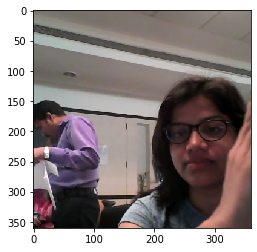

In [5]:
img = imread('Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
plt.imshow(img)

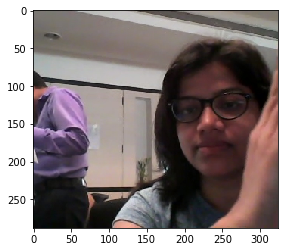

In [6]:
def crop_img(img):
    u, v, w = np.shape(img)
    c1, c2 = int(u/2), int(v/2)
    per1 = int(c1 - u*20/100) # crop 20% of upper part
    per2 = int(c2 - u*10/100) # crop 10% of left part    
    #d1, d2 = per1, c1
    #e1, e2 = per2, c2
    img_croped = img[(c1-per1):u,(c2-per2):v,:]
    return img_croped
plt.imshow(crop_img(img))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
# y,z = 100, 100
# image = imresize(img, (y,z))

# image_r = image
# image_r[:,:,1:2] = 0
# image_g = image
# image_g[:,:,0:2] = 0
# image_b = image
# image_b[:,:,0:1] = 0
# nr = (image_r[:,:,0] - image_r.mean())/image_r.std()#normalise and feed in the image
# ng = (image_g[:,:,1] - image_g.mean())/image_g.std()
# nb = (image_b[:,:,2] - image_b.mean())/image_b.std()
# plt.imshow(image_b)    
# -------------------------------------
# image = imresize(img, (y,z))
# image1 = image/127.5-1
# nr = image1[:,:,0]#normalise and feed in the image
# nb = image1[:,:,1]#normalise and feed in the image
# ng = image1[:,:,2]#normalise and feed in the image
# plt.subplot(1,3,1)
# plt.imshow(nr) 
# plt.subplot(1,3,2)
# plt.imshow(nb) 
# plt.subplot(1,3,3)
# plt.imshow(ng) 
# image = imresize(img, (y,z))
# plt.imshow(image)

In [8]:
img_idx = [1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,26,27,28,29]
x=len(img_idx)
y,z = 100, 100

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,26,27,28,29]#list(range(30))#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        remaining_size = len(folder_list)%batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y,z = 100, 100
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = crop_img(image)
                    image = imresize(image,(y,z))
#                     image_r = image
#                     image_r[:,:,1:2] = 0
#                     batch_data[folder,idx,:,:,0] = (image_r[:,:,0] - image_r.mean())/image_r.std()#normalise and feed in the image
#                     image_g = image
#                     image_g[:,:,0:2] = 0
#                     batch_data[folder,idx,:,:,1] = (image_g[:,:,1] - image_g.mean())/image_g.std()#normalise and feed in the image
#                     image_b = image
#                     image_b[:,:,0:1] = 0
#                     batch_data[folder,idx,:,:,2] = (image_b[:,:,2] - image_b.mean())/image_b.std() #normalise and feed in the image
                    image1 = image/127.5-1
                    nr = image1[:,:,0]#normalise and feed in the image
                    nb = image1[:,:,1]#normalise and feed in the image
                    ng = image1[:,:,2]#normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = nr#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = nb#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = ng#normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        batch = batch +1 
        
        batch_data = np.zeros((remaining_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(remaining_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                image = crop_img(image)
                image = imresize(image,(y,z))
                image1 = image/127.5-1
                nr = image1[:,:,0]#normalise and feed in the image
                nb = image1[:,:,1]#normalise and feed in the image
                ng = image1[:,:,2]#normalise and feed in the image
                batch_data[folder,idx,:,:,0] = nr#normalise and feed in the image
                batch_data[folder,idx,:,:,1] = nb#normalise and feed in the image
                batch_data[folder,idx,:,:,2] = ng#normalise and feed in the image
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## CNN model

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras
from keras.layers import Dropout
#write your model here
input_shape = (x, y, z, 3)
model = Sequential()

model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

# model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

# #Flatten Layers
# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# #softmax layer
# model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 19, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 100, 100, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 19, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 50, 50, 8)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 50, 50, 16)     3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 50, 50, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 9, 50, 50, 16)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
# train_path

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 5
Source path =  Project_data/train ; batch size = 5
Epoch 1/10
133/133 [==============================] - 168s 1s/step - loss: 11.2384 - categorical_accuracy: 0.2301 - val_loss: 13.2168 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-10-2814_44_12.894773/model-00001-11.23836-0.23008-13.21684-0.18000.h5
Epoch 2/10
133/133 [==============================] - 47s 354ms/step - loss: 10.3604 - categorical_accuracy: 0.2617 - val_loss: 11.5577 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2020-10-2814_44_12.894773/model-00002-10.36040-0.26165-11.55772-0.22000.h5
Epoch 3/10
133/133 [==============================] - 46s 349ms/step - loss: 4.3542 - categorical_accuracy: 0.2782 - val_loss: 1.4647 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-10-2814_44_12.894773/model-00003-4.35423-0.27820-1.46470-0.44000.h5
Epoch 4/10
133/133 [=========================

In [17]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

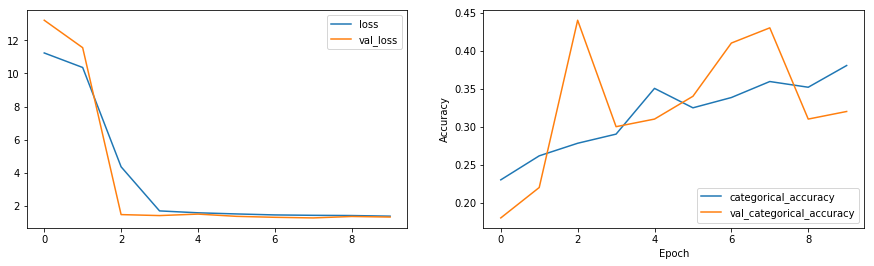

In [21]:
plot(history)

## Simple RNN model with transfer learning 

In [18]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN

In [19]:
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 10


In [32]:
model_1 = Sequential()
model_1.add(TimeDistributed(pretrained_mobilenet,input_shape=input_shape))
# model_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model_1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_1.add(TimeDistributed(BatchNormalization()))
model_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_1.add(TimeDistributed(Flatten()))

# model_1.add(GRU(128))
# model_1.add(LSTM(128))
model_1.add(SimpleRNN(128))
model_1.add(Dropout(0.25))

model_1.add(Dense(128,activation='relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(5, activation='softmax'))

In [33]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 19, 3, 3, 1024)    3228864   
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 19, 3, 3, 16)      442384    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 19, 3, 3, 16)      64        
_________________________________________________________________
time_distributed_7 (TimeDist (None, 19, 1, 1, 16)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 19, 16)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               18560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

In [34]:
history = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 5
Epoch 1/10
 ; batch size = 5
133/133 [==============================] - 59s 443ms/step - loss: 1.4505 - categorical_accuracy: 0.3835 - val_loss: 1.5844 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-10-2806_48_16.992302/model-00001-1.45054-0.38346-1.58440-0.40000.h5
Epoch 2/10
133/133 [==============================] - 50s 372ms/step - loss: 1.0789 - categorical_accuracy: 0.5759 - val_loss: 1.2473 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-10-2806_48_16.992302/model-00002-1.07891-0.57594-1.24730-0.54000.h5
Epoch 3/10
133/133 [==============================] - 51s 382ms/step - loss: 0.8624 - categorical_accuracy: 0.6932 - val_loss: 0.7976 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-10-2806_48_16.992302/model-00003-0.86244-0.69323-0.79763-0.60000.h5
Epoch 4/10
133/133 [==============================]

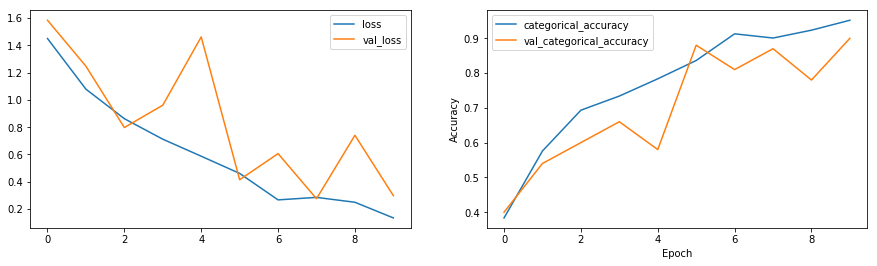

In [35]:
plot(history)

## LSTM model with transfer learning 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 19, 3, 3, 1024)    3228864   
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 19, 3, 3, 16)      442384    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 19, 3, 3, 16)      64        
_________________________________________________________________
time_distributed_11 (TimeDis (None, 19, 1, 1, 16)      0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 19, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
__________

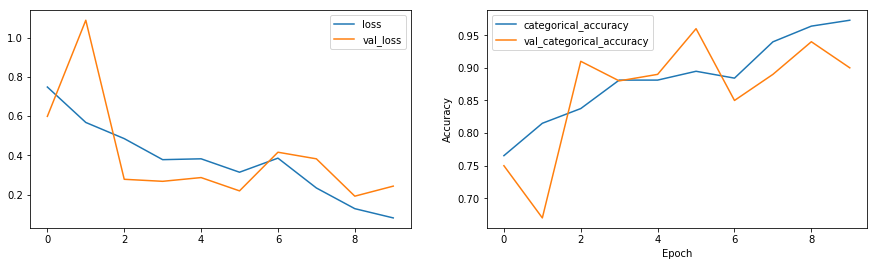

In [36]:
model_2 = Sequential()
model_2.add(TimeDistributed(pretrained_mobilenet,input_shape=input_shape))
# model_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model_2.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

# model_1.add(GRU(128))
model_2.add(LSTM(128))
# model_1.add(SimpleRNN(128))
model_2.add(Dropout(0.25))

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(5, activation='softmax'))

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot(history)

## GRU model without transfer learning 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 19, 100, 100, 8)   656       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 19, 100, 100, 8)   32        
_________________________________________________________________
time_distributed_14 (TimeDis (None, 19, 50, 50, 8)     0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 19, 20000)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               7729536   
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
__________

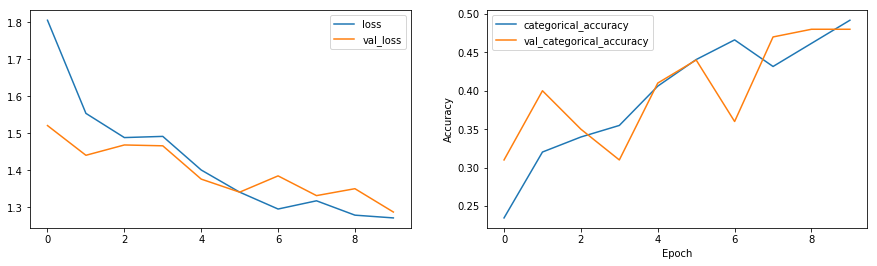

In [37]:
model_2 = Sequential()
# model_2.add(TimeDistributed(pretrained_mobilenet,input_shape=input_shape))
model_2.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
# model_2.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))

model_2.add(GRU(128))
# model_2.add(LSTM(128))
# model_1.add(SimpleRNN(128))
model_2.add(Dropout(0.25))

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(5, activation='softmax'))

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot(history)

## GRU model with transfer learning 

# epochs = 20
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 19, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 19, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)

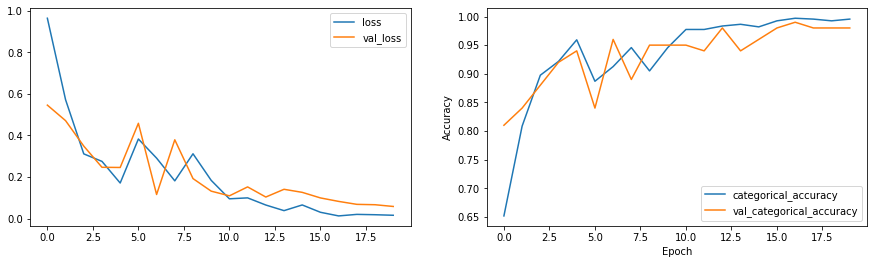

In [20]:
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
model_3 = Sequential()
model_3.add(TimeDistributed(pretrained_mobilenet,input_shape=input_shape))
# model_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
# model_3.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_3.add(TimeDistributed(Flatten()))

model_3.add(GRU(128))
# model_2.add(LSTM(128))
# model_1.add(SimpleRNN(128))
model_3.add(Dropout(0.25))

model_3.add(Dense(128,activation='relu'))
model_3.add(Dropout(0.25))

model_3.add(Dense(5, activation='softmax'))

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot(history)

## Test the model

In [17]:
import time
from keras.models import load_model
#Lets load our best model
# model_pred = load_model('model_init_2020-10-2814_44_12.894773/model-00020-0.02315-0.99549-0.15460-0.96000.h5')
model_pred = load_model('model_init_2020-10-2909_47_17.818196\model-00017-0.01262-0.99698-0.08250-0.99000.h5')

In [22]:
# Left_Swipe - 0
# Right_Swipe - 1
# Stop - 2
# Thumbs_Down - 3
# Thumbs_Up - 4

In [18]:
# def generator_test(source_path, folder_list, batch_size):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = [1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,26,27,28,29]#list(range(30))#create a list of image numbers you want to use for a particular video
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(folder_list)//batch_size # calculate the number of batches
#         remaining_size = len(folder_list)%batch_size
        
#         for batch in range(num_batches): # we iterate over the number of batches
#             x=len(img_idx)
#             y,z = 100, 100
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             #vid = []
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
#                     #crop the images and resize them. Note that the images are of 2 different shape 
#                     #and the conv3D will throw error if the inputs in a batch have different shapes
#                     image = crop_img(image)
#                     image = imresize(image,(y,z))
#                     image1 = image/127.5-1
#                     nr = image1[:,:,0]#normalise and feed in the image
#                     nb = image1[:,:,1]#normalise and feed in the image
#                     ng = image1[:,:,2]#normalise and feed in the image
#                     batch_data[folder,idx,:,:,0] = nr#normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = nb#normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = ng#normalise and feed in the image
#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                 print(source_path+'/'+ t[folder + (batch*batch_size)].strip())
#                 #vid.append(source_path+'/'+ t[folder + (batch*batch_size)].strip())
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
#         # write the code for the remaining data points which are left after full batches
#         batch = batch +1 
        
#         batch_data = np.zeros((remaining_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#         batch_labels = np.zeros((remaining_size,5)) # batch_labels is the one hot representation of the output
#         for folder in range(remaining_size): # iterate over the batch_size
#             imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#             for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
#                 image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

#                 #crop the images and resize them. Note that the images are of 2 different shape 
#                 #and the conv3D will throw error if the inputs in a batch have different shapes
#                 image = crop_img(image)
#                 image = imresize(image,(y,z))
#                 image1 = image/127.5-1
#                 nr = image1[:,:,0]#normalise and feed in the image
#                 nb = image1[:,:,1]#normalise and feed in the image
#                 ng = image1[:,:,2]#normalise and feed in the image
#                 batch_data[folder,idx,:,:,0] = nr#normalise and feed in the image
#                 batch_data[folder,idx,:,:,1] = nb#normalise and feed in the image
#                 batch_data[folder,idx,:,:,2] = ng#normalise and feed in the image
#             batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             print(source_path+'/'+ t[folder + (batch*batch_size)].strip())
#         yield batch_data, batch_labels

In [19]:
def get_vid_data(vid_src):
    
    batch_data = np.zeros((1,x,y,z,3)) 
    batch_labels = np.zeros((1,5)) 
#     vid_src1 = vid_src.split(';')[0]
    imgs = os.listdir(vid_src) # read all the images in the folder    
    
    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
        image = imread(vid_src+'/'+imgs[item]).astype(np.float32)

        #crop the images and resize them. Note that the images are of 2 different shape 
        #and the conv3D will throw error if the inputs in a batch have different shapes
        image = crop_img(image)
        image = imresize(image,(y,z))
        image1 = image/127.5-1
        nr = image1[:,:,0]
        nb = image1[:,:,1]
        ng = image1[:,:,2]
        batch_data[0,idx,:,:,0] = nr#normalise and feed in the image
        batch_data[0,idx,:,:,1] = nb#normalise and feed in the image
        batch_data[0,idx,:,:,2] = ng#normalise and feed in the image
    
    return batch_data

### Test the model with a given video input

In [20]:
vid_src = 'Project_data/train/WIN_20180907_16_03_09_Pro_Thumbs Down_new'#;Thumbs Down_new;3'#'Project_data/train/WIN_20180926_17_38_25_Pro_Stop_new;Stop_new;2'
vid_data = get_vid_data(vid_src)
print(np.argmax(model_pred.predict(vid_data[:,:,:,:,:]),axis=1))

[3]


### Test the model with a batch of videos

In [21]:
def pred_vid_batch(choice, n):
    
    if choice == 'train':
        path = 'Project_data/train'
        doc = train_doc
    else:
        path = 'Project_data/val'
        doc = val_doc

    vids = [t.split(';')[0] for t in doc]
    labels = [int(t.split(';')[-1][:-1]) for t in doc]
    vid_inx = np.random.permutation(range(len(vids)))[:n].tolist()
    pred = []
    act = []
    for i in vid_inx:
        print(path + '/' +vids[i], labels[i])
        vid_src = path + '/' +vids[i]
        vid_data = get_vid_data(vid_src)
        y_pred = np.argmax(model_pred.predict(vid_data[:,:,:,:,:]),axis=1)[0]
        pred.append(y_pred)
        act.append(labels[i])
    print('Actual labels    =>', act)
    print('Predicted labels =>', pred)

In [22]:
pred_vid_batch('val', 15)

Project_data/val/WIN_20180907_16_21_39_Pro_Left Swipe_new_Left Swipe_new 0
Project_data/val/WIN_20180925_17_30_40_Pro_Stop_new 2
Project_data/val/WIN_20180926_17_03_57_Pro_Right_Swipe_new 1
Project_data/val/WIN_20180925_17_49_40_Pro_Stop_new 2
Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new 1
Project_data/val/WIN_20180907_16_05_32_Pro_Left Swipe_new_Left Swipe_new 0
Project_data/val/WIN_20180907_15_42_17_Pro_Stop Gesture_new 2
Project_data/val/WIN_20180926_17_01_52_Pro_Right_Swipe_new 1
Project_data/val/WIN_20180926_17_24_20_Pro_Thumbs_Down_new 3
Project_data/val/WIN_20180926_17_29_34_Pro_Right_Swipe_new 1
Project_data/val/WIN_20180907_16_39_59_Pro_Thumbs Up_new 4
Project_data/val/WIN_20180926_16_52_49_Pro_Right_Swipe_new 1
Project_data/val/WIN_20180907_16_13_24_Pro_Thumbs Down_new 3
Project_data/val/WIN_20180907_16_31_41_Pro_Stop Gesture_new 2
Project_data/val/WIN_20180925_17_52_42_Pro_Stop_new 2
Actual labels    => [0, 2, 1, 2, 1, 0, 2, 1, 3, 1, 4, 1, 3, 2, 2]
Predicted la

In [23]:
pred_vid_batch('train', 15)

Project_data/train/WIN_20180926_17_40_11_Pro_Stop_new 2
Project_data/train/WIN_20180925_18_03_22_Pro_Thumbs_Down_new 3
Project_data/train/WIN_20180907_16_30_24_Pro_Stop Gesture_new 2
Project_data/train/WIN_20180926_16_49_49_Pro_Thumbs_Up_new 4
Project_data/train/WIN_20180926_17_05_54_Pro_Right_Swipe_new 1
Project_data/train/WIN_20180926_17_32_29_Pro_Thumbs_Down_new 3
Project_data/train/WIN_20180925_17_30_21_Pro_Right_Swipe_new 1
Project_data/train/WIN_20180907_15_57_30_Pro_Stop Gesture_new 2
Project_data/train/WIN_20180926_18_09_50_Pro_Right_Swipe_new 1
Project_data/train/WIN_20180907_16_24_14_Pro_Thumbs Up_new 4
Project_data/train/WIN_20180925_17_51_17_Pro_Thumbs_Up_new 4
Project_data/train/WIN_20180907_16_37_03_Pro_Right Swipe_new 1
Project_data/train/WIN_20180925_17_26_25_Pro_Left_Swipe_new 0
Project_data/train/WIN_20180926_17_19_06_Pro_Thumbs_Down_new 3
Project_data/train/WIN_20180926_17_20_39_Pro_Right_Swipe_new 1
Actual labels    => [2, 3, 2, 4, 1, 3, 1, 2, 1, 4, 4, 1, 0, 3, 1]
P